## Import libraries and define variables

In [1]:
import os
import pandas as pd 
import numpy as np

pd.set_option('display.max_colwidth', None)

from src.utils import load_dataset, binarize_label

DATA_DIR = "data"
VALID_PATH = os.path.join(DATA_DIR, "evaluation_sample.csv")


COL_X, COL_Y = "message", "ind_value"

# Columns to aggregate by and to be aggregated
AGGBY_COLS = ["id", "message"]
AGG_COLS = ['labeller_id', 'label' ,'ind_value']

RANDOM_STATE = 1

## Loading dataset

In [2]:
train_df = load_dataset()
val_df = load_dataset(VALID_PATH)

In [3]:
# Example for training
print(f"Training sample size: {train_df.shape}")
train_df.sample(10, random_state=RANDOM_STATE)

Training sample size: (9291, 3)


,message,labeller_id,label
7782,@lilyperez @EugeFigueroaB ...a los ilegales se les pone en la frontera y se acabó el cuento. Los q defienden inmigrantes q digan cuantos metros cuadrados de su casa tienen disponibles para instalar carpas. Es fácil dar soluciones con el dinero ajeno. Manga de wns cínicos.,19,unknown
7372,"@CofradVeritas22 Muchísimos todos los días entran inmigrantes ilegales de Norte a Sur y de Este a Oeste , estamos sobrepoblados .",18,non-racist
3463,"📌 Extremadura registra tres fallecidos y 60 ingresos en UCI, la cifra más alta de la segunda ola. 📌 Navarra notifica tres muertes por #Covid_19 y 209 nuevos positivos.",9,non-racist
6844,Los nuestros los primeros. -No más colas del hambre llenas de españoles. -Menas recibiendo pagas semanales. -Ayudas a inmigrantes que no cotizan ni tienen un oficio. Basta ya! Es hora de salir a la calle y hacernos escuchar! #PrimeroVox #SoloQuedaVox,17,racist
5857,Canarias 🇪🇸🇮🇨 Dos inmigrantes moros asaltan y acuchillan a joven canario en el centro de Las Palmas de Gran Canaria. La violencia desatada.,14,racist
1288,El Gobierno permitirá al ICO acceder a los datos de morosidad de los clientes de los bancos,5,non-racist
98,La Guardia Civil vigila un albergue en Algeciras con 35 inmigrantes ilegales contagiados,1,racist
6089,@cuatroaldia Tenéis que distorsionar más la imagen de los 15 MENAS que agredieron a esos Jóvenes. Se nota que son la típica manada de magrebíes que tanto defendeis. Y venga a traer más .,14,racist
1262,📌 Navarra reporta 3 muertes por #Covid_19 e incorpora 363 nuevos contagios. 📌 Desalojada una fiesta en Granada que reunió a 270 personas sin usar mascarilla ni guardar la distancia social en un local sin licencia.,4,non-racist
6577,Detenidos 5 jóvenes magrebies que destrozaron un coche de Policía y agredieron a agentes en el Grao de Castellón. Agradezcan a la Mafia del Gobierno Socialcomunista la entrada de inmigrantes ilegales muchos delincuentes y a los que permiten delinquir.😤,15,racist


In [4]:
print(f"Evaluation sample size: {val_df.shape}")
val_df.sample(3, random_state=RANDOM_STATE)

Evaluation sample size: (59, 2)


,message,label
49,Fiscalía abre investigación previa contra Guillermo Lasso en conexión con los papeles de Pandora #Noticias #caribe #americalatina #latinos #mexico #usa #republicadominicana #covi_19,non-racist
2,"@A_ausdenRuthen @SimonLevyMx Pinches musulmanes, todos son iguales. 😂",non-racist
35,🔴Nuevo robo con violencia en el centro de Barcelona. 5 magrebíes detenidos:,racist


## Aggregate labels

### 1. Assign ID to unique message

In [5]:
# Explore unique messages
# ... assign unique id to messages
train_msg_list = train_df.message.to_list()
train_msg_unique = set(train_msg_list)
try:
    train_df.insert(0, 'id', train_df.groupby(train_msg_list, sort=False).ngroup() + 1)
except ValueError:
    print("... id column already exists")

print(train_df.dtypes)
train_df.loc[train_df.id == 1, :].head(3)

id              int64
message        object
labeller_id     int64
label          object
dtype: object


,id,message,labeller_id,label
0,1,"🔴 Un grupo de inmigrantes de botellón y sin mascarilla hacen caso omiso de las indicaciones de la policía local en Badiá del Vallés, que intentaba desalojarlos. CasosAislados",1,non-racist
164,1,"🔴 Un grupo de inmigrantes de botellón y sin mascarilla hacen caso omiso de las indicaciones de la policía local en Badiá del Vallés, que intentaba desalojarlos. CasosAislados",1,racist
344,1,"🔴 Un grupo de inmigrantes de botellón y sin mascarilla hacen caso omiso de las indicaciones de la policía local en Badiá del Vallés, que intentaba desalojarlos. CasosAislados",2,racist


Max index value: 5672
Number of unique messages: 5672


<AxesSubplot:>

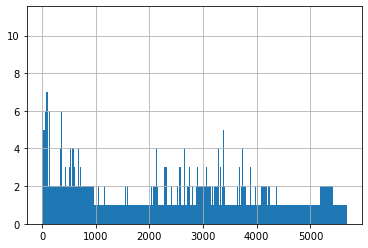

In [6]:
# Visualize annotators per message
print(f"Max index value: {train_df.id.max()}")
print(f"Number of unique messages: {len(train_msg_unique)}")

train_df.id.hist(bins=len(train_msg_unique))

### 2. Convert string labels to floats

In [7]:
# Transform labels to float
def encode_labels(df, col, encoding = None, new_col=None):
    """ 
    Transform values in a column using encoding dict (i.e. keys to values)
    df: pd.DataFrame. Dataframe to encode
    col: String. Name of the column.
    encoding: Dict. {value: to_replace} 
    inplace: Bool. 
    """
    n = df.shape[0]
    if not encoding:
        # Default encoding
        print("... using default encoding [1.0, 0.5, 0.0]")
        encoding = {col: {"non-racist": np.zeros(n), 
                          "racist": np.ones(n),
                          "unknown": np.array([0.5]*n)}}
    if new_col:
        # Save col as new column
        df[new_col] = df.replace(encoding, inplace=False)[col]
        return df
    else:
        return df.replace(encoding, inplace=True)

# encode_labels(train_df, COL_Y)
train_df = encode_labels(train_df, "label", new_col=COL_Y)
train_df.sample(10, random_state=RANDOM_STATE)

... using default encoding [1.0, 0.5, 0.0]


,id,message,labeller_id,label,ind_value
7782,4699,@lilyperez @EugeFigueroaB ...a los ilegales se les pone en la frontera y se acabó el cuento. Los q defienden inmigrantes q digan cuantos metros cuadrados de su casa tienen disponibles para instalar carpas. Es fácil dar soluciones con el dinero ajeno. Manga de wns cínicos.,19,unknown,0.5
7372,2079,"@CofradVeritas22 Muchísimos todos los días entran inmigrantes ilegales de Norte a Sur y de Este a Oeste , estamos sobrepoblados .",18,non-racist,0.0
3463,868,"📌 Extremadura registra tres fallecidos y 60 ingresos en UCI, la cifra más alta de la segunda ola. 📌 Navarra notifica tres muertes por #Covid_19 y 209 nuevos positivos.",9,non-racist,0.0
6844,4096,Los nuestros los primeros. -No más colas del hambre llenas de españoles. -Menas recibiendo pagas semanales. -Ayudas a inmigrantes que no cotizan ni tienen un oficio. Basta ya! Es hora de salir a la calle y hacernos escuchar! #PrimeroVox #SoloQuedaVox,17,racist,1.0
5857,3401,Canarias 🇪🇸🇮🇨 Dos inmigrantes moros asaltan y acuchillan a joven canario en el centro de Las Palmas de Gran Canaria. La violencia desatada.,14,racist,1.0
1288,107,El Gobierno permitirá al ICO acceder a los datos de morosidad de los clientes de los bancos,5,non-racist,0.0
98,99,La Guardia Civil vigila un albergue en Algeciras con 35 inmigrantes ilegales contagiados,1,racist,1.0
6089,3590,@cuatroaldia Tenéis que distorsionar más la imagen de los 15 MENAS que agredieron a esos Jóvenes. Se nota que son la típica manada de magrebíes que tanto defendeis. Y venga a traer más .,14,racist,1.0
1262,945,📌 Navarra reporta 3 muertes por #Covid_19 e incorpora 363 nuevos contagios. 📌 Desalojada una fiesta en Granada que reunió a 270 personas sin usar mascarilla ni guardar la distancia social en un local sin licencia.,4,non-racist,0.0
6577,3952,Detenidos 5 jóvenes magrebies que destrozaron un coche de Policía y agredieron a agentes en el Grao de Castellón. Agradezcan a la Mafia del Gobierno Socialcomunista la entrada de inmigrantes ilegales muchos delincuentes y a los que permiten delinquir.😤,15,racist,1.0


In [8]:
# Save preproc file

fname = os.path.join(DATA_DIR, "labels_racism_preproc.csv")
if not os.path.exists(fname):
    train_df.to_csv(fname, sep='|', index=False)

### 3. Aggregate individual annotations to list

In [9]:
agg_train_df = train_df.groupby(AGGBY_COLS)[AGG_COLS].aggregate(func=list).reset_index()

agg_train_df["n_annotations"] = agg_train_df[COL_Y].apply(len)
print("Max number of annotations in a msg:", format(agg_train_df["n_annotations"].max()))

print(agg_train_df.dtypes)
agg_train_df.head()

Max number of annotations in a msg: 11
id                int64
message          object
labeller_id      object
label            object
ind_value        object
n_annotations     int64
dtype: object


,id,message,labeller_id,label,ind_value,n_annotations
0,1,"🔴 Un grupo de inmigrantes de botellón y sin mascarilla hacen caso omiso de las indicaciones de la policía local en Badiá del Vallés, que intentaba desalojarlos. CasosAislados","[1, 1, 2, 3, 5, 6, 9]","[non-racist, racist, racist, racist, non-racist, racist, racist]","[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]",7
1,2,Recopilamos las principales noticias sobre brotes por #Covid_19 en España. Abrimos hilo 👇,"[1, 2, 3, 6, 9]","[non-racist, non-racist, non-racist, non-racist, non-racist]","[0.0, 0.0, 0.0, 0.0, 0.0]",5
2,3,Esto debería leerlo todo Ecuador. Es el mayor escándalo de imparcialidad de un comité electoral que vi. La elección de las 5 personas por el CNE tienen un sesgo anticorreista y de relaciones con medios y fundaciones financiadas desde EEUU terrible. #LasEleccionesVanPorqueVan,"[1, 2, 3, 6, 9]","[non-racist, non-racist, non-racist, non-racist, non-racist]","[0.0, 0.0, 0.0, 0.0, 0.0]",5
3,4,Más de 300 inmigrantes intentan saltar la valla de Melilla y dejan a tres guardias civiles heridos,"[1, 2, 3, 6, 8, 9]","[non-racist, non-racist, unknown, non-racist, non-racist, non-racist]","[0.0, 0.0, 0.5, 0.0, 0.0, 0.0]",6
4,5,Aena invierte más de 31 millones de euros en el control sanitario de pasajeros. En @transparentia_ te lo explicamos 👇🏼,"[1, 2, 3, 6, 9]","[non-racist, non-racist, non-racist, non-racist, non-racist]","[0.0, 0.0, 0.0, 0.0, 0.0]",5


### 4. Compute majority and weighted majority votes

In [10]:
# Compute majority vote: mean and label

agg_train_df["m_vote"] = agg_train_df[COL_Y].apply(np.mean)
# encoding as non-strict classifier: racist is >= 0.5 (unknowns are racist)
agg_train_df["m_vote_label"] = binarize_label(agg_train_df, "m_vote", thr=0.5, strict=False, inplace=False)

agg_train_df.loc[agg_train_df.m_vote==0.5].head()

,id,message,labeller_id,label,ind_value,n_annotations,m_vote,m_vote_label
14,15,El efecto llamada de Sánchez: las costas de Canarias reciben una media de 147 menas al mes,"[1, 2, 2, 3, 5, 6, 9]","[racist, unknown, non-racist, non-racist, non-racist, racist, racist]","[1.0, 0.5, 0.0, 0.0, 0.0, 1.0, 1.0]",7,0.5,racist
39,40,Cientos de inmigrantes ilegales del CETI Melilla se manifiestan para exigir su traslado a la península,"[1, 2, 3, 6, 8, 9]","[racist, non-racist, racist, non-racist, non-racist, racist]","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0]",6,0.5,racist
46,47,🔴Asesinada una niña de 8 años en Pakistán por dejar escapar unos loros de la familia para la que trabajaba como empleada doméstica. ¡Wellcome to Europa!,"[1, 2, 2, 3, 4, 6, 8, 9, 9]","[non-racist, unknown, non-racist, racist, non-racist, racist, racist, non-racist, racist]","[0.0, 0.5, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]",9,0.5,racist
101,102,"📺 @monasterioR ""Yo no veo a las feministas estas que nos ponen murales en Ciudad Lineal hablar y manifestarse porque las educadores que están en los centros de menas son acosadas"".","[1, 5]","[non-racist, racist]","[0.0, 1.0]",2,0.5,racist
116,117,La Guardia Civil busca a dos inmigrantes ilegales en cuarentena huidos de un albergue en Granada,"[1, 5]","[racist, non-racist]","[1.0, 0.0]",2,0.5,racist


In [11]:
def compute_weighted_majority_vote(labels, weight_perc=None, max_annotations=11):
    """ Compute mean from annotations weighted by the number of labellers
    labels: List. List of labels
    weight_perc: np.float64. Weight by the percentage reached by the annotations. Default: 0.8
    max_annotations: np.float64. Max number of annotations for a text in the dataframe.
    """
    if not weight_perc:
        weight_perc=0.8
        # weight by the number of annotations in the message. Default: 0.2
        weight_num=0.2
    else:
        weight_num=1.0-weight_perc
        

    n = len(labels)
    perc = np.mean(labels)
    if perc > 0.5:
        # The majority said this is racist (e.g. will have higher prob with a higher number of annotations)
        w_m_vote = weight_perc*perc + weight_num*(n/max_annotations)
    else:
        # The majority this is not racist
        w_m_vote = weight_perc*np.mean(labels) + weight_num*(1-n/max_annotations)
    return w_m_vote

agg_train_df["w_m_vote"] = agg_train_df[COL_Y].apply(lambda row: compute_weighted_majority_vote(row, weight_perc=0.85))
# encoding as non-strict classifier: racist is > 0.35 
agg_train_df["w_m_vote_label"] = binarize_label(agg_train_df, "w_m_vote", thr=0.35, strict=False, inplace=False)


agg_train_df.loc[(agg_train_df.w_m_vote<0.4)&(agg_train_df.w_m_vote>0.3)].head()

,id,message,labeller_id,label,ind_value,n_annotations,m_vote,m_vote_label,w_m_vote,w_m_vote_label
114,115,✊🏿 Irene Montero anuncia una 'regularización masiva' de mujeres inmigrantes,"[1, 5, 8]","[non-racist, racist, non-racist]","[0.0, 1.0, 0.0]",3,0.333333,non-racist,0.392424,racist
124,125,"""El racismo institucional no ve personas, solo ve migrantes""","[1, 5]","[non-racist, unknown]","[0.0, 0.5]",2,0.250000,non-racist,0.335227,non-racist
127,128,"""Hoy responde..."", con @anadebande de @populares : ""Todos los días llegan a Madrid inmigrantes de Italia procedentes de Canarias"" #Hoyresponde","[1, 4, 5, 9]","[non-racist, non-racist, non-racist, racist]","[0.0, 0.0, 0.0, 1.0]",4,0.250000,non-racist,0.307955,non-racist
168,169,Andalucía ha recibido 5.150 inmigrantes ilegales desde el inicio de la pandemia de coronavirus Última hora Andalucía,"[1, 5, 8]","[racist, non-racist, non-racist]","[1.0, 0.0, 0.0]",3,0.333333,non-racist,0.392424,racist
195,196,Fuerteventura rechaza el realojo de inmigrantes en hoteles de la isla ordenado por el Gobierno,"[1, 2, 5, 6]","[racist, non-racist, non-racist, non-racist]","[1.0, 0.0, 0.0, 0.0]",4,0.250000,non-racist,0.307955,non-racist


In [12]:
# Explore cases: 
# 
# A. the more agreement in racist annotations, the highest racism probability (e.g. id 3654)
agg_train_df.sort_values(by="m_vote", ascending=False).head(20).sample(10, random_state=RANDOM_STATE)

,id,message,labeller_id,label,ind_value,n_annotations,m_vote,m_vote_label,w_m_vote,w_m_vote_label
3650,3651,@Papiruspalporr1 @Alvisepf @jcccvvv @Renfe Por cierto con lo de la manada te refieres a los moros que violaron a la niña de 14 años??🤔🤔,"[14, 15]","[racist, racist]","[1.0, 1.0]",2,1.0,racist,0.877273,racist
3632,3633,"@sanchezcastejon Nos esclavizan a impuestos, roban a nuestros hijos para pagar a etarras, políticos que sobran, chiringuitos de infecciosas y vagos, MENAs africanos y yihadistas. Esto es el PSOE, comunismo por esclavitud, trabajadores pagando a vagos. Tu sin hijos, y los mojameses con 300.",[14],[racist],[1.0],1,1.0,racist,0.863636,racist
3647,3648,"Así debería ser con todos los inmigrantes delincuentes, al patio de los callaos y listo. Santo remedio.",[14],[racist],[1.0],1,1.0,racist,0.863636,racist
3639,3640,"@LAZASA1 @hermanntertsch @TfIrene @IdiazAyuso Y para que quiere Ayuso esa mayoría,para dar más presupuesto a menas, a... feminazis?, seguirá apoyando la VIOGEN? Se seguirá llenando Madrid de ilegales , ghettos,okupas ?...el paraíso Ayuso","[14, 21]","[racist, racist]","[1.0, 1.0]",2,1.0,racist,0.877273,racist
3651,3652,"En Perú, el presidente Castillo le dio 72 horas a los inmigrantes delincuentes para que abandonen el pais, de seguro se vendrán a Chile, acá los proteje la justicia y las organización es internacionales, estamos cagados con este sistema de administración de justicia... 🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️",[14],[racist],[1.0],1,1.0,racist,0.863636,racist
3633,3634,"Me acaban de decir que hace un par de horas intentaron violar a unas chicas en el Barrio un grupo de chavales menas que están en un piso de acogida , tienes alguna info @silcerino @3stebanvd ??",[14],[racist],[1.0],1,1.0,racist,0.863636,racist
1585,1586,"📍Las Palmas de Gran Canaria. ➡️Gran despliegue💰 para nuestros ""queridos"" futuros DELINCUENTES INMIGRANTES🤬 👉Para ellos no hay HORARIOS, paga España. ⁉️Has escuchado eso de ""CAVARSE la PROPIA TUMBA "" ⁉️... pues eso. #LaÑEstáEnPeligro #LevantandoEspaña #SoloQuedaVox","[8, 10]","[racist, racist]","[1.0, 1.0]",2,1.0,racist,0.877273,racist
3653,3654,@ImperialShinto Pensaba que el pueblo canario estaba despertando. Pero se ve que hay gente que sigue creyendo que los menas alojados en hoteles vienen de una guerra. Una grandisima pena.,"[14, 19, 20, 22]","[racist, racist, racist, racist]","[1.0, 1.0, 1.0, 1.0]",4,1.0,racist,0.904545,racist
3646,3647,Esa es la realidad de #RepublicaDominicana En los barrios la #juventud no se respeta el distanciamiento social. Y peor es en barrios donde la mayoría son #inmigrantes #haitianos,[14],[racist],[1.0],1,1.0,racist,0.863636,racist
3679,3680,@vicente210157 Somos un grupo llamado Fuera Venezolanos del Peru que nacio porque estamos hartos de los inmigrantes venezolanos con su horrible comportamiento matonesco y tambien por los peruanos(nas) que fueron victimas de su despiadada de estos delincuentes venezolanos hacia los peruanos(na,[14],[racist],[1.0],1,1.0,racist,0.863636,racist


In [13]:
# B. the more agreement in non-racist annotations, the lowest probability value (e.g. id 2131)
agg_train_df.sort_values(by="m_vote").head(20).sample(10, random_state=RANDOM_STATE)

,id,message,labeller_id,label,ind_value,n_annotations,m_vote,m_vote_label,w_m_vote,w_m_vote_label
2135,2136,"@LaiaBrBa @CapitanBitcoin Claro, pone inmigrantes no acompañados. No pueden poner ""menas"" que significa lo mismo a fin de cuentas; aunque sea políticamente incorrecto.",[10],[non-racist],[0.0],1,0.0,non-racist,0.136364,non-racist
2169,2170,¿@elisabeni que pensará ahora del chico al que un grupo de inmigrantes apodados los Koalas dieron la paliza en Amorebieta y que anuncian hoy que problamente no salga del coma?...,[10],[non-racist],[0.0],1,0.0,non-racist,0.136364,non-racist
2142,2143,"@rortizvalen @RNapG8 @Sinfiltros_tv @ClementePerezE @ivanguerrerom @Naty_campusano @CF_Salas @airarrazavala @sebas_vergara Con 3 años de Gobierno Socialista, entendí que las ideologías son nefastas, han pasado más de 45 años y lo he confirmado, países que han llegado a la pobreza,hoy suma el narcotráfico más inmigrantes ilegales, Foros de Sao Paulo, Puebla. De muestra un botón del pte Argentina🤷‍♀️🤦‍♀️",[10],[non-racist],[0.0],1,0.0,non-racist,0.136364,non-racist
2157,2158,"Una sensación de mareó embargó a Luka y por un momento creyó que iba a desmayarse, puntos negros salpicaban su visión y sus pulmones pedían a gritos la entrada de oxígeno. Sin embargo, el contrario era increíblemente fuerte, más fuerte incluso que los músculos de »",[10],[non-racist],[0.0],1,0.0,non-racist,0.136364,non-racist
2130,2131,"@verorebonatto @CarlosP58185334 Hay que entenderlos, están acostumbrados a huir de su país, no a recibir inmigrantes! No conocen Venezuela, ni sus mercados, ni sus barrios, llenos de extranjeros! O como dices tú, otros países, son los mismos que se quejan de xenofobia en Europa, pero se comportan igual.","[10, 11, 12, 15]","[non-racist, non-racist, non-racist, non-racist]","[0.0, 0.0, 0.0, 0.0]",4,0.0,non-racist,0.095455,non-racist
2166,2167,@irene_menas Hacia el fin de los nuevos comienzos.,[10],[non-racist],[0.0],1,0.0,non-racist,0.136364,non-racist
2138,2139,"Decretan la expulsión de extranjeros irregulares sorprendidos en cumpleaños clandestino. Un total de 16 personas, entre ellos extranjeros, junto a menores de edad, participaron en un cumpleaños infantil en Villa Alemana. #inmigrantes",[10],[non-racist],[0.0],1,0.0,non-racist,0.136364,non-racist
2175,2176,"Para que os enteréis, fachas: -Los ilegales q entran agrediendo a Guardias Civiles, los q violan, los q roban, los q agreden a ancianas, los contagiados de #COVID19 q escapan: NO INCITAN EL #RACISMO -Los q SÍ lo promueven son LOS QUE SE QUEJAN de lo anterior Black Lives Matter",[10],[non-racist],[0.0],1,0.0,non-racist,0.136364,non-racist
2144,2145,"@elindepcom Por qué no decís que el grupo de siete personas eran menas ilegales ?? Buscais la subvención, borregos ¿periodistas? 🤔",[10],[non-racist],[0.0],1,0.0,non-racist,0.136364,non-racist
2129,2130,El 'rookie' Binder da la campanada en Brno y Márquez sonríe en la distancia,[10],[non-racist],[0.0],1,0.0,non-racist,0.136364,non-racist


In [14]:
# TODO: check this cell or remove.

# C. What happens with the unknowns? In this exploration, we show cases of the non-strict classifier (i.e. thr is 0.35, and all unknowns fall into the racist category)
print("Unknown majority vote samples with a weighted vote non-racist: {}".format(agg_train_df.loc[(agg_train_df.m_vote==0.5)&(agg_train_df.w_m_vote_label=="non-racist")].shape[0]))
print("Unknown majority vote samples with a weighted vote racist: {}".format(agg_train_df.loc[(agg_train_df.m_vote==0.5)&(agg_train_df.w_m_vote_label=="racist")].shape[0]))


# C.1. unknowns with highest weighted majority vote: 
agg_train_df.loc[agg_train_df.m_vote == 0.5,:].sort_values(by="w_m_vote", ascending=False).sample(20, random_state=RANDOM_STATE)

Unknown majority vote samples with a weighted vote non-racist: 0
Unknown majority vote samples with a weighted vote racist: 475


,id,message,labeller_id,label,ind_value,n_annotations,m_vote,m_vote_label,w_m_vote,w_m_vote_label
1178,1179,La 'llamada' de la izquierda surte efecto: llegan a Andalucía 326 inmigrantes en patera este fin de semana,"[7, 10]","[non-racist, racist]","[0.0, 1.0]",2,0.5,racist,0.547727,racist
4799,4800,@Ivan_Rockero_1 (ya sé que solo dice inmigrantes y nada de legales o ilegales pero es OBVIO que se refiere a los ilegales y sino es Twitter aue está lleno de retrasados progresistas y conservadores extremos pero no hagas caso porque son opiniones que NADIE toma en cuenta),"[19, 21]","[racist, non-racist]","[1.0, 0.0]",2,0.5,racist,0.547727,racist
4017,4018,Nuevas agresiones a educadores y detenciones de 'menas' en el polémico centro de la Casa de Campo,[15],[unknown],[0.5],1,0.5,racist,0.561364,racist
3093,3094,Deportación de los inmigrantes ilegales a sus países de origen. #ArribaVOXveceremos #VoxExtremaNecesidad #SiguemeYTeSigoVox,"[11, 12, 17, 18]","[non-racist, non-racist, racist, racist]","[0.0, 0.0, 1.0, 1.0]",4,0.5,racist,0.520455,racist
5355,5356,@mmlamoyano El programa con los gitanos 👏👏👏,"[20, 22]","[non-racist, racist]","[0.0, 1.0]",2,0.5,racist,0.547727,racist
5247,5248,"YA NO LO PUEDEN OCULTAR. PERO SIGUEN LLAMANDO RACISTA A VOX. ""La Policía detiene a 55 jóvenes en otra noche de violencia y robos en el botellón del Parque del Oeste. La mayoría son marroquíes o magrebíes. Hay varios menores entre los apresados""","[20, 22]","[racist, non-racist]","[1.0, 0.0]",2,0.5,racist,0.547727,racist
2155,2156,@EmpresarioVox No inmigrantes ilegales votando. Hijos de 16 tb tenemos los de derechas.,[10],[unknown],[0.5],1,0.5,racist,0.561364,racist
5187,5188,"@laSextaTV Que lástima. Si @PSOE y @PODEMOS no se gastaran el dinero en menas, venezuela, terroristas vascos. Quizá se hubiera pillado a tiempo.","[20, 22]","[non-racist, racist]","[0.0, 1.0]",2,0.5,racist,0.547727,racist
4394,4395,"#laventanaindiscreta #ULTIMAHORA Los vecinos del Puerto de la Cruz relatan q los MENAS o exmenas de la Consejera @noepmp piden dinero a las personas q se quieren sentar en los bancos públicos, la población siente presión x su presencia hostil y pérdida de identidad de su pueblo!",[17],[unknown],[0.5],1,0.5,racist,0.561364,racist
2266,2267,"@chazarordz @adanmartinezt @RCampuzano @Magazzo1 @jeyc1987 @El_Compa_Marco @papapirupo @Juliosucks3 @albertordzrom @robertsranduks @cancerbero56 @scguajardo @juanchitotopo @2OSITOO @GildoGarzaMx @MISTER_OPTIMUS @annabau @Tampico_Follow @mariocancino01 @rigobertoher @AnibalMSilvaMx @ElMeroFondoMX @HankAleman @RamiroRamosSal @mexico_rafael20 @jRomanmtz @FuriaNegra7 @eljuligan1 @DemisAlanMx @Lic_IsmaelPena @ElMameMX @ElMayeloLelo @Enrique12633773 @MiTrincheraV @brujascarlata1 @AlesitaMomoy @Jalife_Victoria @tonypresss @Dulcesoledadd @CambioPress @edgarmelhem @Gerardo_PenaF @erasmoglz @lugo056 @Dr_AVillarreal @ChuchoNader @dect1608 Sabia Calle SABE EXACTAMENTE en que parte del penal de Altamira es donde guardan a los secuestrados que levantan en #Altamira #tampico y #madero Hay inmigrantes , mujeres y hombres @IrvingBarriosM ONTIVEROS y @fgcabezadevaca LO SABEN",[10],[unknown],[0.5],1,0.5,racist,0.561364,racist


In [15]:
# C.2. unknowns with lowest weighted majority vote: 
# Question in the air: with more disagremeent, what is our desired score? 
agg_train_df.loc[agg_train_df.m_vote == 0.5,:].sort_values(by="w_m_vote", ascending=True).head(20)

,id,message,labeller_id,label,ind_value,n_annotations,m_vote,m_vote_label,w_m_vote,w_m_vote_label
46,47,🔴Asesinada una niña de 8 años en Pakistán por dejar escapar unos loros de la familia para la que trabajaba como empleada doméstica. ¡Wellcome to Europa!,"[1, 2, 2, 3, 4, 6, 8, 9, 9]","[non-racist, unknown, non-racist, racist, non-racist, racist, racist, non-racist, racist]","[0.0, 0.5, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]",9,0.5,racist,0.452273,racist
14,15,El efecto llamada de Sánchez: las costas de Canarias reciben una media de 147 menas al mes,"[1, 2, 2, 3, 5, 6, 9]","[racist, unknown, non-racist, non-racist, non-racist, racist, racist]","[1.0, 0.5, 0.0, 0.0, 0.0, 1.0, 1.0]",7,0.5,racist,0.479545,racist
593,594,"🔴Las Fuerzas de Seguridad prestan especial atención estas semanas a la llegada de pateras porque entre los inmigrantes, intentan infiltrarse más elementos yihadistas en territorio nacional, según han informado al periódico La Razón fuentes antiterroristas.","[2, 4, 5, 6, 8, 9, 10]","[unknown, racist, non-racist, non-racist, racist, racist, non-racist]","[0.5, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]",7,0.5,racist,0.479545,racist
39,40,Cientos de inmigrantes ilegales del CETI Melilla se manifiestan para exigir su traslado a la península,"[1, 2, 3, 6, 8, 9]","[racist, non-racist, racist, non-racist, non-racist, racist]","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0]",6,0.5,racist,0.493182,racist
456,457,Llegan 41 inmigrantes ilegales más a Motril en la madrugada de este lunes,"[2, 4, 6, 7, 9, 10]","[non-racist, non-racist, racist, racist, racist, non-racist]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0]",6,0.5,racist,0.493182,racist
2639,2640,"@sebastiansichel Lo que realmente importa es : Araucanía urgente ! Narcoterrorismo, inmigrantes ilegales, menos impuestos , un Estado más pequeño , delincuencia desmedida… en fin, votaste apruebo 😞😞 me cuesta confiar … espero más propuestas","[11, 12, 13, 15, 16]","[non-racist, racist, non-racist, racist, unknown]","[0.0, 1.0, 0.0, 1.0, 0.5]",5,0.5,racist,0.506818,racist
2703,2704,"@DomnguezGrace @RodrigoDelgadoM 🙀Nosotros #Cuarentenados #Inmigrantes #Caribeños llegan al poto del mundo, luego suben a #Buses alcanzando hasta el #Extremo #Sur #ilegales en #pandemia Le agotaron la paciencia hasta a los #Aimaras #Colchane #Iquique #Chile #NoPodi","[11, 15, 17, 18, 19]","[non-racist, non-racist, unknown, racist, racist]","[0.0, 0.0, 0.5, 1.0, 1.0]",5,0.5,racist,0.506818,racist
920,921,"Si hablamos de referéndums que sean para preguntar a los españoles sobre la cosas que de verdad afectan a su vida, a sus libertades y a su economía. ❓ Ilegalización de partidos separatistas: sí o no. ❓ Prisión permanente: sí o no. ❓ Acoger menas: sí o no. ❓ Okupas: sí o no.","[4, 7, 9, 10]","[non-racist, racist, racist, non-racist]","[0.0, 1.0, 1.0, 0.0]",4,0.5,racist,0.520455,racist
878,879,Aumenta la presión migratoria en Andalucía: llegan 61 inmigrantes ilegales más en pateras en lo que va de sábado,"[4, 7, 9, 10]","[racist, non-racist, racist, non-racist]","[1.0, 0.0, 1.0, 0.0]",4,0.5,racist,0.520455,racist
874,875,"El Ejecutivo de Sánchez dice que los inmigrantes habrán llegado a Granada en avión ""con recursos propios""","[4, 5, 7, 9]","[racist, non-racist, non-racist, racist]","[1.0, 0.0, 0.0, 1.0]",4,0.5,racist,0.520455,racist


### 5. Export to csv

In [16]:
# Export to csv

fname = os.path.join(DATA_DIR, "labels_racism_aggregated.csv")
if not os.path.exists(fname):
    agg_train_df.to_csv(fname, sep='|', index=False)

### 6. Import from saved csv

In [17]:
agg_train_df_imported = load_dataset(fname)
agg_train_df_imported.head()

,id,message,labeller_id,label,ind_value,n_annotations,m_vote,m_vote_label,w_m_vote,w_m_vote_label
0,1,"🔴 Un grupo de inmigrantes de botellón y sin mascarilla hacen caso omiso de las indicaciones de la policía local en Badiá del Vallés, que intentaba desalojarlos. CasosAislados","[1, 1, 2, 3, 5, 6, 9]","[non-racist, racist, racist, racist, non-racist, racist, racist]","[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]",7,0.714286,racist,0.702597,racist
1,2,Recopilamos las principales noticias sobre brotes por #Covid_19 en España. Abrimos hilo 👇,"[1, 2, 3, 6, 9]","[non-racist, non-racist, non-racist, non-racist, non-racist]","[0.0, 0.0, 0.0, 0.0, 0.0]",5,0.000000,non-racist,0.081818,non-racist
2,3,Esto debería leerlo todo Ecuador. Es el mayor escándalo de imparcialidad de un comité electoral que vi. La elección de las 5 personas por el CNE tienen un sesgo anticorreista y de relaciones con medios y fundaciones financiadas desde EEUU terrible. #LasEleccionesVanPorqueVan,"[1, 2, 3, 6, 9]","[non-racist, non-racist, non-racist, non-racist, non-racist]","[0.0, 0.0, 0.0, 0.0, 0.0]",5,0.000000,non-racist,0.081818,non-racist
3,4,Más de 300 inmigrantes intentan saltar la valla de Melilla y dejan a tres guardias civiles heridos,"[1, 2, 3, 6, 8, 9]","[non-racist, non-racist, unknown, non-racist, non-racist, non-racist]","[0.0, 0.0, 0.5, 0.0, 0.0, 0.0]",6,0.083333,non-racist,0.139015,non-racist
4,5,Aena invierte más de 31 millones de euros en el control sanitario de pasajeros. En @transparentia_ te lo explicamos 👇🏼,"[1, 2, 3, 6, 9]","[non-racist, non-racist, non-racist, non-racist, non-racist]","[0.0, 0.0, 0.0, 0.0, 0.0]",5,0.000000,non-racist,0.081818,non-racist
